In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch.optim as optim
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn.utils import shuffle

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce RTX 4090


In [3]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [4]:
x = torch.tensor([1, 2, 3])
x = x.cuda(0)

In [5]:
def encode_categorical(series):
    col = series.name
    series_one_hot = pd.get_dummies(series)
    if -9 in series_one_hot.columns:
        series_one_hot = series_one_hot.drop(labels=-9, axis=1)
    series_one_hot.columns = [col+'_'+str(i) for i in series_one_hot.columns]
    return series_one_hot
def scale_continuous(series):
    series = series.copy()
    mean = series.loc[series!=-9].mean()
    series.loc[series==-9] = mean
    series = (series-mean)/series.std()
    return pd.DataFrame(series)

In [34]:
data = pd.read_csv('data/treatments_2017-2020.csv')
data = data.loc[data.REASON!=7]
data = data.reset_index(drop=True)

categorical_features = ['EMPLOY_D', 'MARSTAT', 'PRIMINC', 'TRNQFLG', 'NOPRIOR', 'PREG', 'METHUSE', 'DETNLF_D',
                        'INHFLG', 'SUB1_D', 'ALCDRUG', 'SERVICES', 'ETHNIC', 'SERVICES_D', 'DETNLF', 'PRIMPAY'
                       , 'HERFLG', 'IDU', 'REGION', 'SEDHPFLG', 'BENZFLG', 'OPSYNFLG', 'ALCFLG', 'OTCFLG',
                       'HLTHINS', 'DIVISION', 'GENDER', 'AMPHFLG', 'PCPFLG', 'PSOURCE', 'COKEFLG',  'COKEFLG',
                       'PSYPROB', 'RACE', 'ROUTE1','DETCRIM', 'VET','ARRESTS_D', 'MARFLG','STIMFLG','LIVARAG_D', 'SUB1',
                        'BARBFLG', 'EMPLOY', 'LIVARAG', 'ARRESTS', 'EDUC', 'DSMCRIT', 'METHFLG','OTHERFLG', 'FREQ_ATND_SELF_HELP_D', 'FREQ1_D',
                        'FREQ1', 'FREQ_ATND_SELF_HELP',
                        'metropolitanmicropolitanstatis']
continuous_features = ['AGE', 'LOS', 'FRSTUSE1', 'DAYWAIT']
# continuous_features = ['AGE', 'FRSTUSE1', 'DAYWAIT']

In [35]:
df = data[['DISYR', 'STFIPS', 'CBSA', 'REASON']]
for i in range(len(categorical_features)):
    df = pd.concat([df, encode_categorical(data[categorical_features[i]])], axis=1)
for i in range(len(continuous_features)):
    df = pd.concat([df, scale_continuous(data[continuous_features[i]])], axis=1)
del data

state_data = pd.read_csv('acs_5yr_state_normalized.csv')
CBSA_data = pd.read_csv('acs_5yr_CBSA_normalized.csv')
facility_data = pd.read_csv('facilities_by_state_normalized.csv')

In [36]:
train, test = pickle.load(open('split.p', 'rb'))

# a small batch
ind = train[:100]

def load_batch(ind):
    batch = df.loc[ind]
    batch = pd.merge(batch, state_data, how="left", left_on=["STFIPS", "DISYR"], right_on=["fips", "Year"])
    batch = batch.drop(labels=["fips", "Year"], axis=1)
#     batch = pd.merge(batch, CBSA_data, how="left", left_on=["CBSA", "DISYR"], right_on=["CBSA", "Year"])
#     batch = batch.drop(labels=[ "Year"], axis=1)
    batch = pd.merge(batch, facility_data, how="left", left_on=["STFIPS", "DISYR"], right_on=["state_fips", "year"])
    batch = batch.drop(labels=["state_fips", "year"], axis=1)
    X = batch.values[:, 4:]
    y = batch.REASON.values
    y = np.int16(y==1)
    return X, y

In [37]:
input_dim = load_batch(ind)[0].shape[1]
output_dim = 1
hidden_dim = [256, 512, 512, 256]
print(input_dim,hidden_dim, output_dim)
print(load_batch(ind)[0].shape)

852 [256, 512, 512, 256] 1
(100, 852)


In [38]:
class ANNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256).double()
        self.relu1 = nn.ReLU().double()
        self.fc2 = nn.Linear(256, 512).double()
        self.relu2 = nn.ReLU().double()
        self.fc3 = nn.Linear(512, 512).double()
        self.drop1 = nn.Dropout(p=0.2)
        self.relu3 = nn.ReLU().double()
        self.fc4 = nn.Linear(512, 64).double()
        self.relu4 = nn.ReLU().double()
        self.fc5 = nn.Linear(64, output_dim).double()
        self.sigmoid = nn.Sigmoid().double()
    def forward(self, input):
        out = self.fc1(input)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.drop1(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        out = self.sigmoid(out)
        return out

In [39]:
Model = ANNModel(input_dim,hidden_dim, output_dim)
model = Model.to(device)
print(model)

ANNModel(
  (fc1): Linear(in_features=852, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (relu3): ReLU()
  (fc4): Linear(in_features=512, out_features=64, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [40]:
CrossEntropyLoss = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [41]:
def get_acc(outputs, labels):
    predict = torch.where(outputs>0.5, 1.0, 0.0)
    total_num = labels.shape[0]
    correct_num = (labels==predict).sum().item()
    acc = correct_num/total_num
    return correct_num, acc

In [28]:
epoch_num = 50 
batch_size = 100000
train_acc = []
test_acc = []
train_loss = []
test_loss = []
for epoch in tqdm.trange(epoch_num):
    running_loss = 0
    running_acc = 0
    running_correct = 0
    last_loss = 0
    last_acc = 0
    for i in range(0, train.shape[0], batch_size):
#         torch.cuda.empty_cache()
        if i+batch_size-1<train.shape[0]:
            indx = train[i:i+batch_size]
        else: indx = train[i:]
        batch_X_train, batch_y_train = load_batch(indx)
        batch_X_train = torch.from_numpy(batch_X_train)
        batch_y_train = torch.from_numpy(batch_y_train)
        batch_X_train, batch_y_train = batch_X_train.to(device), batch_y_train.to(device, dtype=torch.float64)
        model.zero_grad()
        optimizer.zero_grad()
        outputs = model(batch_X_train)
        loss = CrossEntropyLoss(outputs.flatten(), batch_y_train)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        temp, running_acc = get_acc(outputs.flatten(), batch_y_train)
        running_correct += temp
    train = shuffle(train)
    last_loss = running_loss / train.shape[0] # loss per epoch
    last_acc = running_correct/ train.shape[0]
    print('  epoch {} training loss: {} acc: {}'.format(epoch + 1, last_loss, last_acc))
    train_acc.append(last_acc)
    train_loss.append(last_loss)
    running_loss = 0
    running_acc = 0
    running_correct = 0
    last_loss = 0
    last_acc = 0
    for i in range(0, test.shape[0], batch_size):
#         torch.cuda.empty_cache()
            if i+batch_size-1<test.shape[0]:
                indx = test[i:i+batch_size]
            else: indx = test[i:]
            batch_X_test, batch_y_test = load_batch(indx)
            batch_X_test = torch.from_numpy(batch_X_test)
            batch_y_test = torch.from_numpy(batch_y_test)
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device, dtype=torch.float64)
            outputs_test = model(batch_X_test)
            loss = CrossEntropyLoss(outputs_test.flatten(), batch_y_test)
            running_loss += loss.item()
            temp, running_acc = get_acc(outputs_test.flatten(), batch_y_test)
            running_correct += temp
    last_loss = running_loss / test.shape[0] # loss per epoch
    last_acc = running_correct/ test.shape[0]
    print('  epoch {} testing loss: {} acc: {}'.format(epoch +1, last_loss, last_acc))
    test_acc.append(last_acc)
    test_loss.append(last_loss)
    

  0%|          | 0/50 [00:00<?, ?it/s]

  epoch 1 training loss: 4.760493655840404 acc: 0.5902132752551924


  2%|▏         | 1/50 [01:08<55:35, 68.07s/it]

  epoch 1 testing loss: 4.733817566972491 acc: 0.6538193179502695
  epoch 2 training loss: 4.740656808681477 acc: 0.6746997498930588


  4%|▍         | 2/50 [02:16<54:47, 68.49s/it]

  epoch 2 testing loss: 4.719237282116954 acc: 0.6828277339722019
  epoch 3 training loss: 4.729219691483352 acc: 0.7037284149408282


  6%|▌         | 3/50 [03:24<53:16, 68.02s/it]

  epoch 3 testing loss: 4.71035095930452 acc: 0.7169538899145637
  epoch 4 training loss: 4.7254995640672925 acc: 0.7135001147452638


  8%|▊         | 4/50 [04:29<51:22, 67.01s/it]

  epoch 4 testing loss: 4.707969146886188 acc: 0.7104365669875417
  epoch 5 training loss: 4.720664309105539 acc: 0.7254816471039427


 10%|█         | 5/50 [05:34<49:44, 66.31s/it]

  epoch 5 testing loss: 4.704201505041197 acc: 0.7279807516172387
  epoch 6 training loss: 4.718367236462973 acc: 0.7312971223122766


 12%|█▏        | 6/50 [06:40<48:20, 65.93s/it]

  epoch 6 testing loss: 4.706517748632735 acc: 0.7334164850296073
  epoch 7 training loss: 4.71875293459047 acc: 0.7301047320672363


 14%|█▍        | 7/50 [07:44<47:00, 65.60s/it]

  epoch 7 testing loss: 4.702652366276523 acc: 0.724795671172089
  epoch 8 training loss: 4.715850682932264 acc: 0.7369877327193461


 16%|█▌        | 8/50 [08:50<45:52, 65.54s/it]

  epoch 8 testing loss: 4.699805503223467 acc: 0.7441757793927868
  epoch 9 training loss: 4.714878029857163 acc: 0.7397385317340119


 18%|█▊        | 9/50 [09:55<44:43, 65.45s/it]

  epoch 9 testing loss: 4.698858830455916 acc: 0.7361837487830831
  epoch 10 training loss: 4.714227596769805 acc: 0.7411806515815808


 20%|██        | 10/50 [11:00<43:30, 65.27s/it]

  epoch 10 testing loss: 4.70149726779937 acc: 0.7255819075081453
  epoch 11 training loss: 4.7217832367442165 acc: 0.6896430478949133


 22%|██▏       | 11/50 [12:05<42:26, 65.31s/it]

  epoch 11 testing loss: 4.704052604598762 acc: 0.7003914715997851


 22%|██▏       | 11/50 [12:46<45:18, 69.71s/it]


KeyboardInterrupt: 

In [ ]:
PATH = 'data/state_fac_model_los_final.pth'
torch.save(model.state_dict(), PATH)

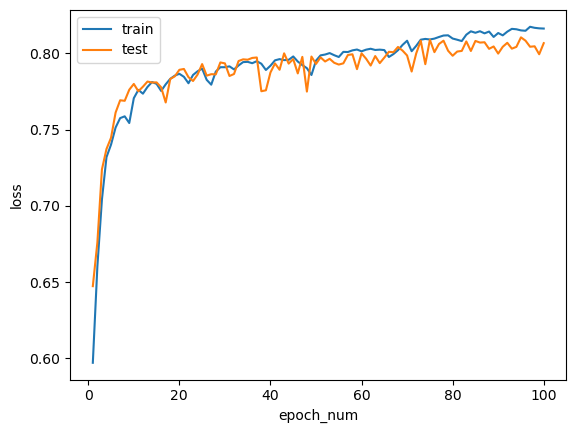

In [17]:
num = np.arange(0,100)+1
plt.plot(num, train_acc, label='train')
plt.plot(num, test_acc, label='test')
plt.xlabel('epoch_num')
plt.ylabel('loss')
plt.legend()

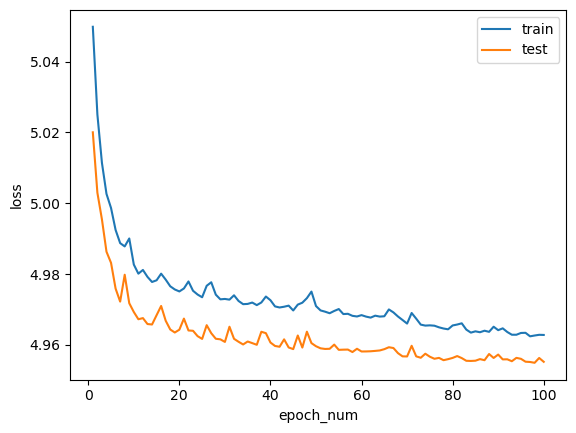

In [19]:
num = np.arange(0,100)+1
plt.plot(num, train_loss, label='train')
plt.plot(num, test_loss, label='test')
plt.xlabel('epoch_num')
plt.ylabel('loss')
plt.legend()

In [42]:
PATH = 'data/state_fac_model_2.pth'
model.load_state_dict(torch.load(PATH))
model.eval()

ANNModel(
  (fc1): Linear(in_features=852, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (relu3): ReLU()
  (fc4): Linear(in_features=512, out_features=64, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [27]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

X_test, y_test = load_batch(test[0:50000])
X_test = torch.from_numpy(X_test)
# y_test = torch.from_numpy(y_test)
X_test= X_test.to(device)
y_pred_test = model.forward(X_test)
y_pred_test = torch.where(y_pred_test>0.5, 1.0, 0.0)
y_pred_test = y_pred_test.cpu().detach().numpy()
print(f1_score(y_test, y_pred_test))
print(roc_auc_score(y_test, y_pred_test))

0.7870665251238501
0.8154579239244271


In [43]:
running_loss = 0
running_acc = 0
running_correct = 0
last_loss = 0
last_acc = 0
batch_size = 100000
for i in range(0, test.shape[0], batch_size):
#         torch.cuda.empty_cache()
            if i+batch_size-1<test.shape[0]:
                indx = test[i:i+batch_size]
            else: indx = test[i:]
            batch_X_test, batch_y_test = load_batch(indx)
            batch_X_test = torch.from_numpy(batch_X_test)
            batch_y_test = torch.from_numpy(batch_y_test)
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device, dtype=torch.float64)
            outputs_test = model(batch_X_test)
            loss = CrossEntropyLoss(outputs_test.flatten(), batch_y_test)
            running_loss += loss.item()
            temp, running_acc = get_acc(outputs_test.flatten(), batch_y_test)
            running_correct += temp
last_loss = running_loss / test.shape[0] # loss per epoch
last_acc = running_correct/ test.shape[0]
print('  epoch {} testing loss: {} acc: {}'.format(1, last_loss, last_acc))

  epoch 1 testing loss: 4.65540507238985 acc: 0.8354491735256525


In [128]:
import shap
def load_batch2(ind):
    batch = df.loc[ind]
    batch = pd.merge(batch, state_data, how="left", left_on=["STFIPS", "DISYR"], right_on=["fips", "Year"])
    batch = batch.drop(labels=["fips", "Year"], axis=1)
#     batch = pd.merge(batch, CBSA_data, how="left", left_on=["CBSA", "DISYR"], right_on=["CBSA", "Year"])
#     batch = batch.drop(labels=[ "Year"], axis=1)
    batch = pd.merge(batch, facility_data, how="left", left_on=["STFIPS", "DISYR"], right_on=["state_fips", "year"])
    batch = batch.drop(labels=["state_fips", "year"], axis=1)
    X = batch.values[:, 4:]
    y = batch.REASON.values
    y = np.int16(y==1)
    return X, y, batch.columns[4:]
batch_size = 3000
torch.set_grad_enabled(True)
ind = test[:batch_size]
test_data, _,feature_name = load_batch2(ind)
e = shap.DeepExplainer(model, Variable( torch.from_numpy( test_data).to(device) ) ) 

In [129]:
feature_name

Index(['EMPLOY_D_1', 'EMPLOY_D_2', 'EMPLOY_D_3', 'EMPLOY_D_4', 'MARSTAT_1',
       'MARSTAT_2', 'MARSTAT_3', 'MARSTAT_4', 'PRIMINC_1', 'PRIMINC_2',
       ...
       'REVCHK1', 'REVCHK8', 'REVCHK5', 'REVCHK10', 'REVCHK15', 'REVCHK2',
       'REVCHK17', 'LOC5', 'LICEN', 'ACCRED'],
      dtype='object', length=852)

In [130]:
# Get the shap values from my test data (this explainer likes tensors)
shap_values = e.shap_values( Variable( torch.from_numpy( test_data).to(device)) )

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [131]:
print(shap_values.shape)

(3000, 852)


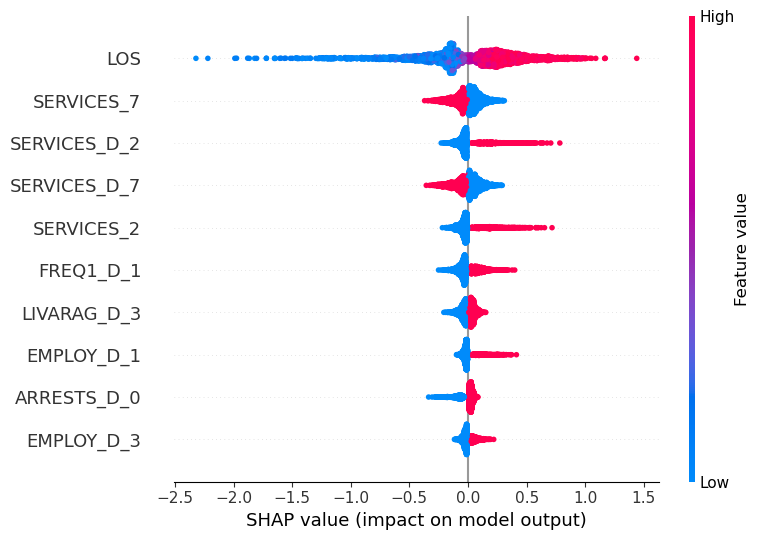

In [133]:
# Plots
#shap.force_plot(explainer.expected_value, shap_values, feature_name)
#shap.dependence_plot("b1_price_avg", shap_values, data, feature_name)
shap.summary_plot(shap_values, test_data, feature_name, max_display=10)

In [221]:
def load_batch3(ind):
    batch = df.loc[ind]
    batch = pd.merge(batch, state_data, how="left", left_on=["STFIPS", "DISYR"], right_on=["fips", "Year"])
    batch = batch.drop(labels=["fips", "Year"], axis=1)
#     batch = pd.merge(batch, CBSA_data, how="left", left_on=["CBSA", "DISYR"], right_on=["CBSA", "Year"])
#     batch = batch.drop(labels=[ "Year"], axis=1)
    batch = pd.merge(batch, facility_data, how="left", left_on=["STFIPS", "DISYR"], right_on=["state_fips", "year"])
    batch = batch.drop(labels=["year"], axis=1)

    return batch

In [222]:
stfips = [15, 20, 16, 21, 18, 37]

In [223]:
batch = load_batch3(test)

In [224]:
a = batch[batch['STFIPS']==8]
a = a.iloc[:, 4:]
a = a.drop(labels=["state_fips"], axis=1)
feature_name = a.columns
torch.set_grad_enabled(True)
test_data = a.values[0:3000]


In [225]:
test_data.shape

(3000, 852)

In [226]:
import shap
e = shap.DeepExplainer(model, Variable( torch.from_numpy( test_data).to(device) ) ) 

In [ ]:
shap_values = e.shap_values( Variable( torch.from_numpy( test_data).to(device)) )


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
shap.summary_plot(shap_values, test_data, feature_name, max_display=10)

In [195]:
print(shap_values, shap_values.shape)

[[-8.96182095e-03  1.21921657e-01 -1.31426138e-02 ...  3.74027248e-03
  -1.68513386e-03  7.42545432e-04]
 [-9.83012110e-03 -4.26018583e-03  2.55738853e-02 ...  9.53342987e-05
  -4.14840129e-06 -6.13256253e-06]
 [-1.56804501e-02 -6.92869987e-03 -1.37608292e-02 ... -3.00047978e-03
   1.87038865e-03 -2.31022126e-03]
 ...
 [-1.41356324e-02 -6.14971044e-03 -1.24425086e-02 ...  3.40153535e-04
   5.24430733e-05 -1.64220858e-04]
 [-3.94560764e-02 -1.81885355e-02 -3.66625813e-02 ...  2.25939014e-03
  -3.32365099e-05 -1.15775828e-03]
 [ 1.73040905e-01 -5.82094739e-03 -1.68752898e-02 ...  3.13977108e-03
  -4.31285843e-04  4.36218590e-05]] (3000, 852)


In [154]:
test_data

array([[ 0.        ,  0.        ,  0.        , ..., -0.64245528,
        -0.34894403, -0.72375016],
       [ 0.        ,  0.        ,  0.        , ..., -0.64245528,
        -0.34894403, -0.72375016],
       [ 0.        ,  0.        ,  0.        , ..., -0.57593131,
        -0.40548589, -0.72375016],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.57593131,
        -0.35702144, -0.71734841],
       [ 1.        ,  0.        ,  0.        , ..., -0.57593131,
        -0.40548589, -0.72375016],
       [ 0.        ,  0.        ,  0.        , ..., -0.57593131,
        -0.35702144, -0.71734841]])